In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     1825 non-null   datetime64[ns]
 1   s_1      1825 non-null   float64       
 2   s_2      1825 non-null   float64       
 3   s_3      1825 non-null   float64       
 4   holiday  1825 non-null   bool          
 5   weather  1825 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(4)
memory usage: 73.2 KB


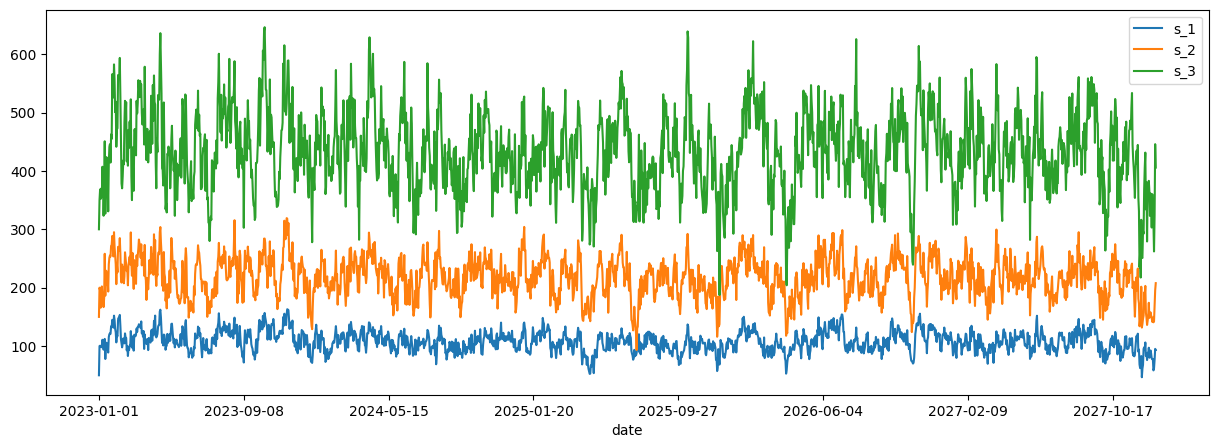

In [ ]:
import pandas as pd

df = pd.read_csv("data/linear_dep_time_series.csv")
series = ["s_1", "s_2", "s_3"]
df.set_index("date")[series].plot(figsize=(15, 5))
df.head()

df["date"] = pd.to_datetime(df["date"])
df["holiday"] = df["holiday"].astype(bool)

# df.info()

# melt the series and prepare for the model

df_demand = df.melt(
    id_vars=["date"], value_vars=series, var_name="series_id", value_name="value"
)

# create exog dataframe for holiday and	weather
df_exog_temp = df[["date", "holiday", "weather"]].drop_duplicates()

#replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)
df_exog["series_id"] = ""
for brand in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = brand
    df_exog = pd.concat([df_exog, df_exog_brand])


## Dataset

Dataset dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=1825)
Train dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2026-12-31 00:00:00'))  (n=1461)
Test dates      : (Timestamp('2026-12-31 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=365)


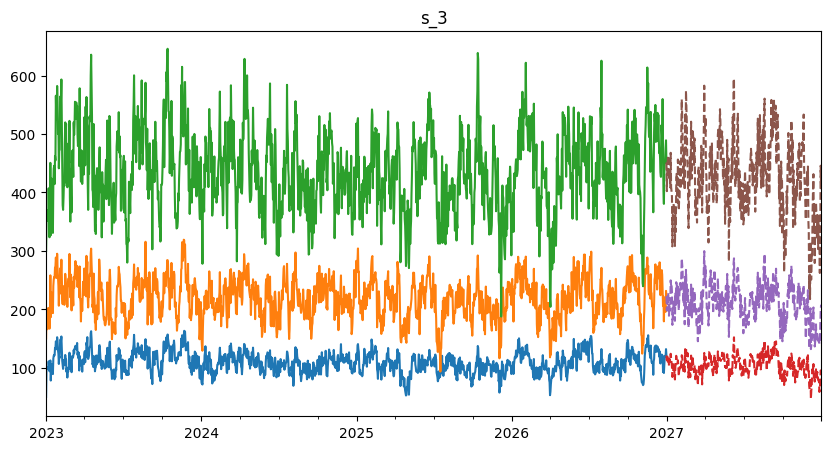

In [51]:
from tsxp.dataset import ForecasterMsDataset, DatasetMapping
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection  import TimeSeriesFold

# define split date
split_date = "2026-12-31"



mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)

dataset.show_sizes()
dataset.plot_series()


In [52]:


def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [4, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
    }


regressor = LGBMRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster = ForecasterMsExog( 
    data = dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)
forecaster.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  



  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 0.507296
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_

(            levels          lags  \
 0  [s_1, s_2, s_3]  [1, 2, 3, 4]   
 1  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 2  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 3  [s_1, s_2, s_3]  [1, 2, 3, 4]   
 4  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 5  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 6  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 7  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 8  [s_1, s_2, s_3]  [1, 2, 3, 4]   
 9  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 
                                               params  \
 0  {'n_estimators': 449, 'max_depth': 7, 'learnin...   
 1  {'n_estimators': 574, 'max_depth': 8, 'learnin...   
 2  {'n_estimators': 897, 'max_depth': 10, 'learni...   
 3  {'n_estimators': 349, 'max_depth': 9, 'learnin...   
 4  {'n_estimators': 1185, 'max_depth': 9, 'learni...   
 5  {'n_estimators': 853, 'max_depth': 8, 'learnin...   
 6  {'n_estimators': 1083, 'max_depth': 15, 'learn...   
 7  {'n_estimators': 351, 'max_depth': 6, 'learnin...   
 8  {'n_estimators': 293, 'max_depth': 9, 'learnin...   
 9  {'n_estimators': 

c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\utils\utils.py:1036: MissingValuesWarning: To make predictions `exog` for series 's_1' must start one step ahead of `last_window`. Missing values are filled with NaN.
    `last_window` ends at : 2026-12-31 00:00:00.
    `exog` for series 's_1' starts at : 2026-12-31 00:00:00.
     Expected index       : 2027-01-01 00:00:00. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\utils\utils.py:1036: MissingValuesWarning: To make predictions `exog` for series 's_2' must start one step ahead of `last_window`. Missing values are filled with NaN.
    `last_window` ends at : 2026-12-31 00:00:00.
    `exog` for series 's_2' starts at : 2026-12-31 00:00:00.
     Expected index       : 2027-01-01 00:00:00. 
 You can suppress this warning using: warnings.simplefilter('ignore', ca

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_sa

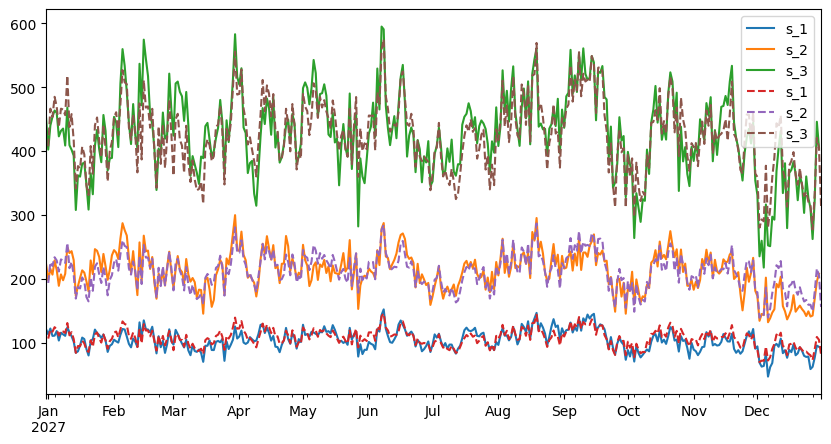

In [53]:
forecaster.plot_forecast()

In [54]:
from tsxp.explainers import ForecasterMsExogFeatureImportance
fi = ForecasterMsExogFeatureImportance(forecaster)


display(fi.feature_importance)
display(fi.feature_rank)
display(fi.relative_feature_importance)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18


PFI_MSE_TEST  SHAP_TEST
weather                0.015784   0.072507
lag_1                  0.015414   0.073081
lag_2                  0.001232   0.020043
holiday                0.000156   0.007547
lag_3                  0.000017   0.002540
_level_skforecast      0.000011   0.001300
lag_4                 -0.000001   0.001068

Rank          
                  PFI_MSE_TEST SHAP_TEST
weather                      1         2
lag_1                        2         1
lag_2                        3         3
holiday                      4         4
lag_3                        5         5
_level_skforecast            6         6
lag_4                        7         7

Perc           
                  PFI_MSE_TEST  SHAP_TEST
weather              48.397061  40.714549
lag_1                47.261274  41.036838
lag_2                 3.777152  11.254440
holiday               0.478961   4.237841
lag_3                 0.053475   1.426449
_level_skforecast     0.035160   0.730109
lag_4                -0.003082   0.599774

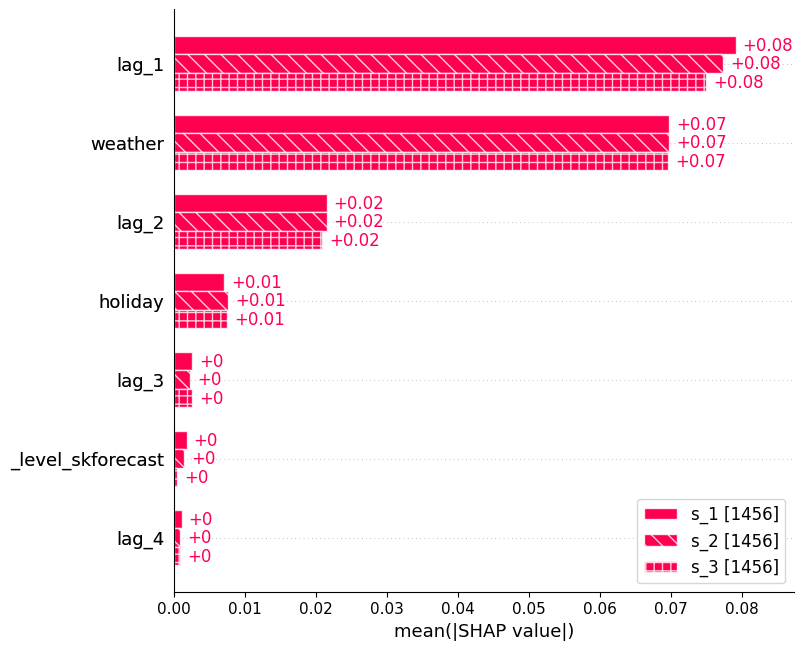

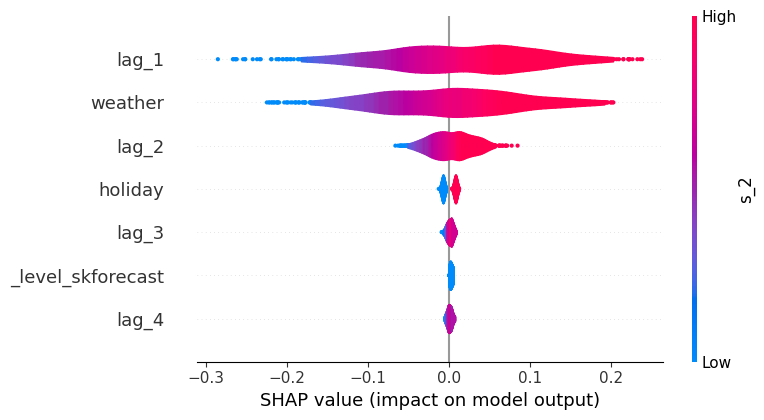

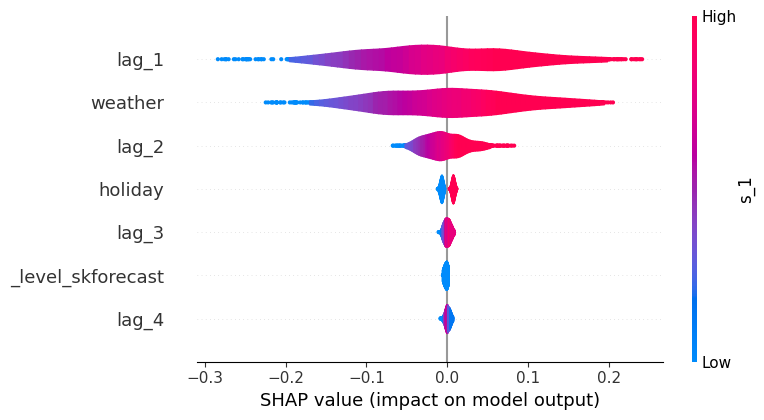

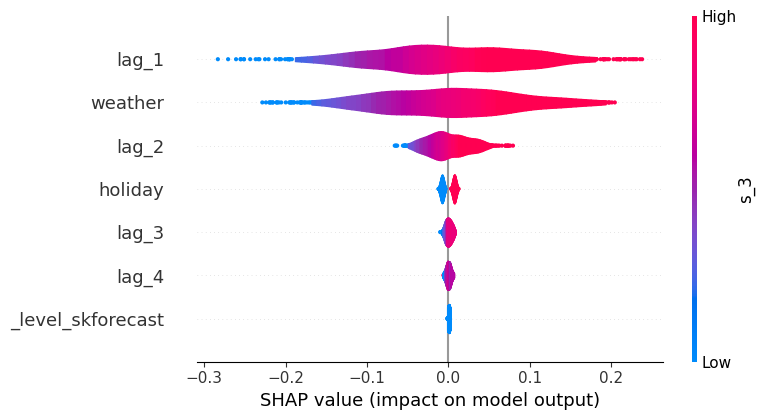

In [55]:
fi.plot_importance_for_series()

Dataset dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=1825)
Train dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2026-12-31 00:00:00'))  (n=1461)
Test dates      : (Timestamp('2026-12-31 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=365)


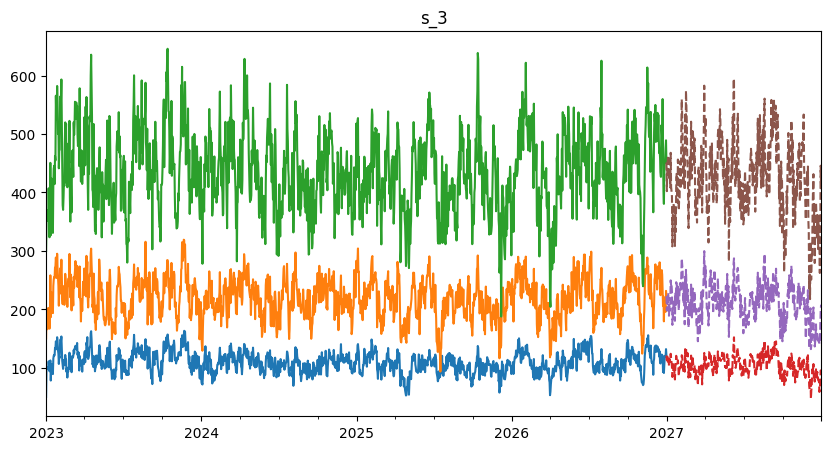

In [56]:
from tsxp.dataset import ForecasterMsDataset, DatasetMapping
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection  import TimeSeriesFold

# define split date
split_date = "2026-12-31"

# df_exog["holiday"] = df_exog["holiday"].astype(bool) # SHAP has problems with bool

df_exog["holiday"] = df_exog["holiday"].astype(int) # bool is not supported by SHAP


mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)

dataset.show_sizes()
dataset.plot_series()


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 265.407917
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_chil

PFI_MSE_TEST  SHAP_TEST
lag_1              11682.337911  58.725770
_level_skforecast   4934.414833  54.456127
weather             1412.447769  19.557152
lag_2                430.450740   9.676216
holiday               18.703553   2.368767
lag_4                 10.463009   1.720124
lag_5                 10.003249   0.660491

Rank          
                  PFI_MSE_TEST SHAP_TEST
lag_1                        1         1
_level_skforecast            2         2
weather                      3         3
lag_2                        4         4
holiday                      5         5
lag_4                        6         6
lag_5                        7         7

Perc           
                  PFI_MSE_TEST  SHAP_TEST
lag_1                63.151797  39.904808
_level_skforecast    26.674212  37.003538
weather               7.635339  13.289301
lag_2                 2.326909   6.575096
holiday               0.101107   1.609603
lag_4                 0.056560   1.168843
lag_5                 0.054075   0.448811

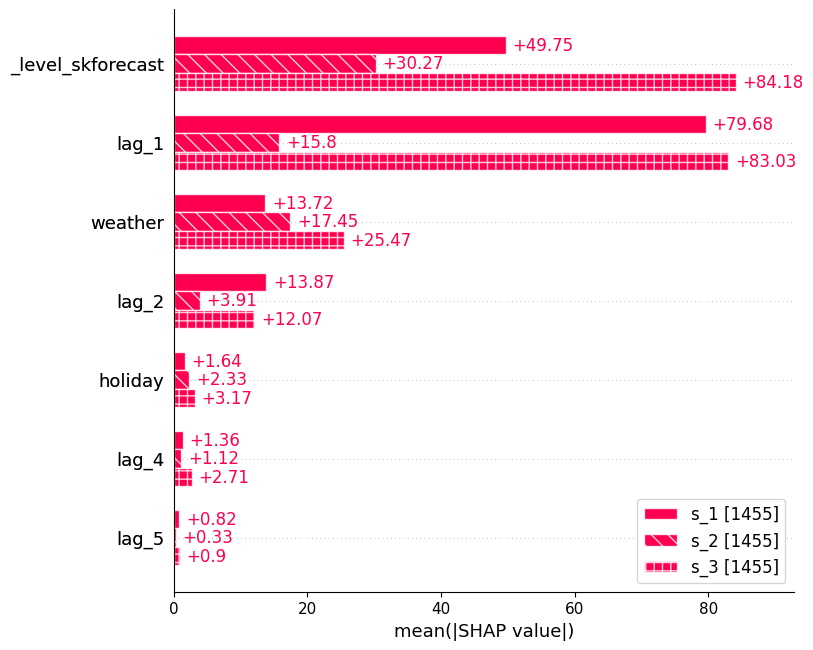

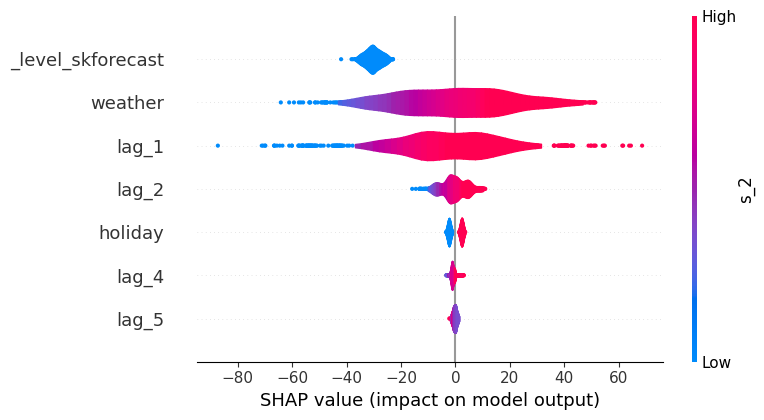

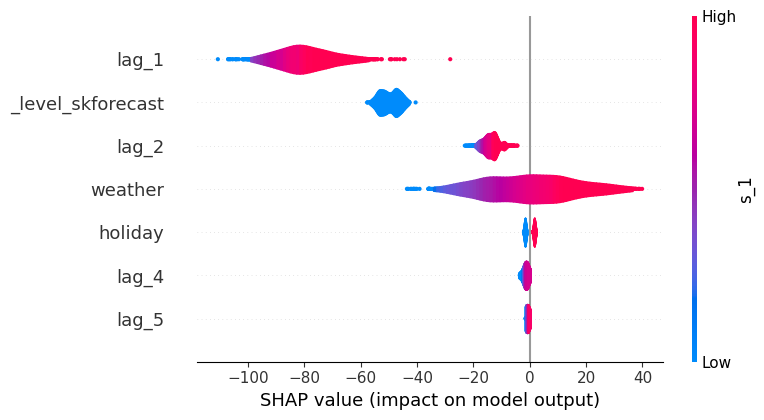

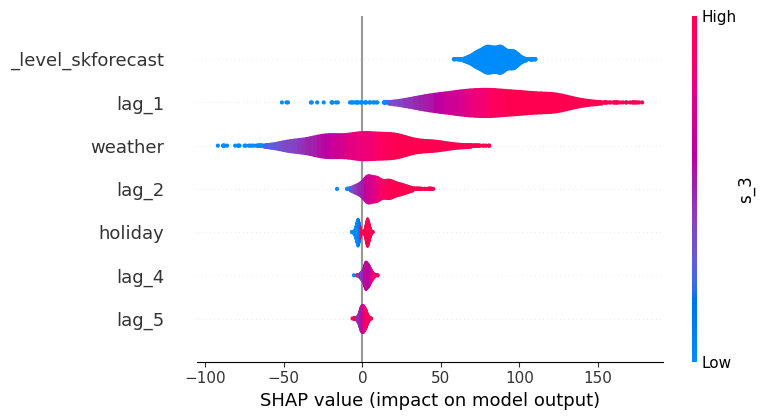

In [57]:
def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [ 4, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
    }


regressor = LGBMRegressor()
print(regressor.get_params())

# scaler = MinMaxScaler()
scaler = None

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster = ForecasterMsExog( 
    data = dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)

forecaster.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  

fi = ForecasterMsExogFeatureImportance(forecaster)


display(fi.feature_importance)
display(fi.feature_rank)
display(fi.relative_feature_importance)




In [ ]:
fi.plot_importance_for_series()

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


## Different contributions

C:\Users\Matty\AppData\Local\Temp\ipykernel_39460\232093518.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exog = pd.concat([df_exog, df_exog_brand])


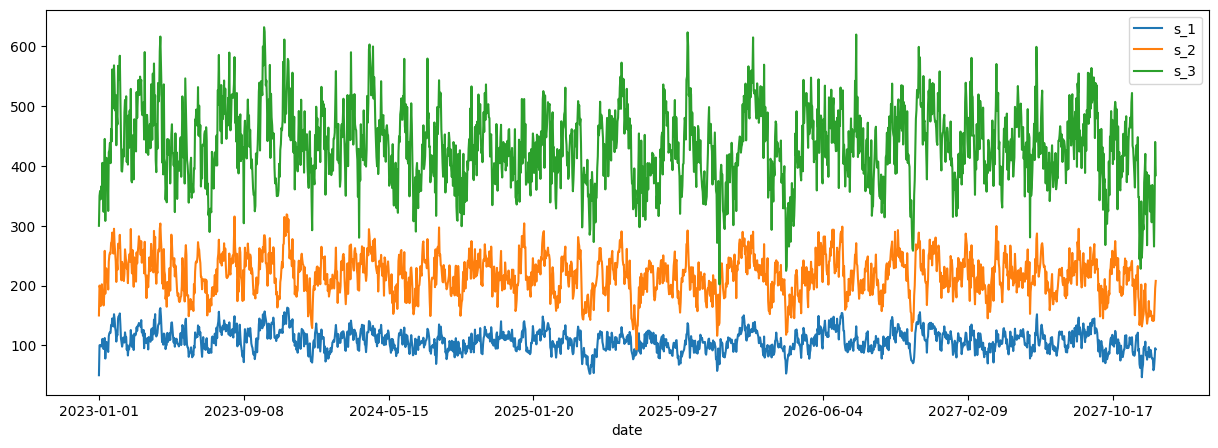

In [66]:
import pandas as pd

df = pd.read_csv("data/linear_dep_different_factors.csv")
series = ["s_1", "s_2", "s_3"]
df.set_index("date")[series].plot(figsize=(15, 5))
df.head()

df["date"] = pd.to_datetime(df["date"])
df["holiday"] = df["holiday"].astype(bool)

# df.info()

# melt the series and prepare for the model

df_demand = df.melt(
    id_vars=["date"], value_vars=series, var_name="series_id", value_name="value"
)

# create exog dataframe for holiday and	weather
df_exog_temp = df[["date", "holiday", "weather"]].drop_duplicates()

#replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)
df_exog["series_id"] = ""
for brand in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = brand
    df_exog = pd.concat([df_exog, df_exog_brand])


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 0.508354
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf

PFI_MSE_TEST  SHAP_TEST
weather                0.016882   0.075624
lag_1                  0.011661   0.065780
lag_2                  0.003128   0.032030
holiday                0.000182   0.008656
_level_skforecast      0.000118   0.003376
lag_5                 -0.000006   0.001894
lag_4                 -0.000009   0.002331

Rank          
                  PFI_MSE_TEST SHAP_TEST
weather                      1         1
lag_1                        2         2
lag_2                        3         3
holiday                      4         4
_level_skforecast            5         5
lag_5                        6         7
lag_4                        7         6

Perc           
                  PFI_MSE_TEST  SHAP_TEST
weather              52.831046  39.867087
lag_1                36.490761  34.677811
lag_2                 9.787716  16.885408
holiday               0.569368   4.563076
_level_skforecast     0.368396   1.779615
lag_5                -0.018409   0.998346
lag_4                -0.028876   1.228657

 99%|===================| 4334/4365 [01:52<00:00]        

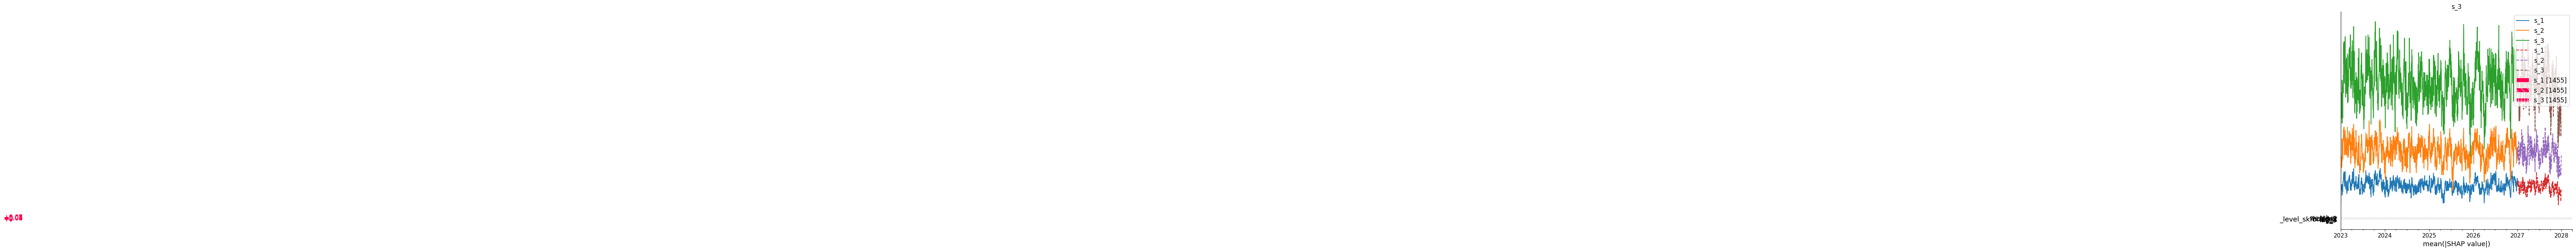

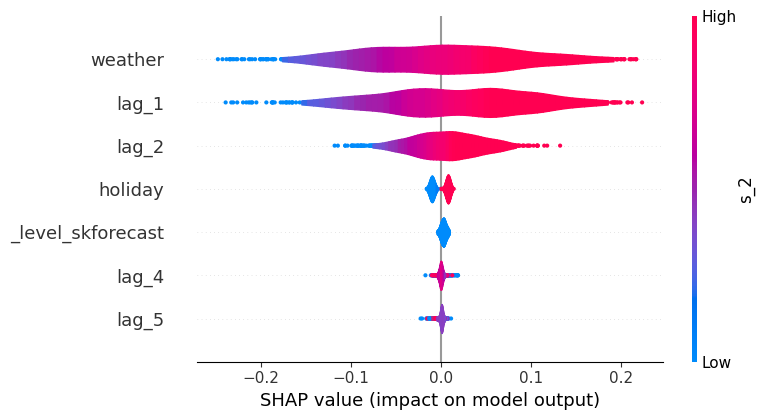

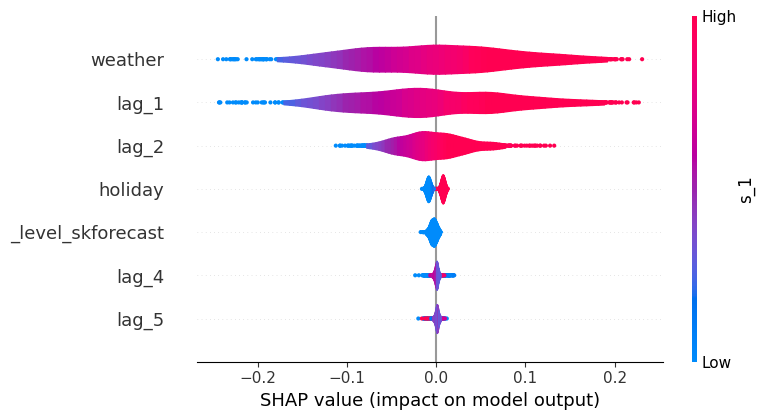

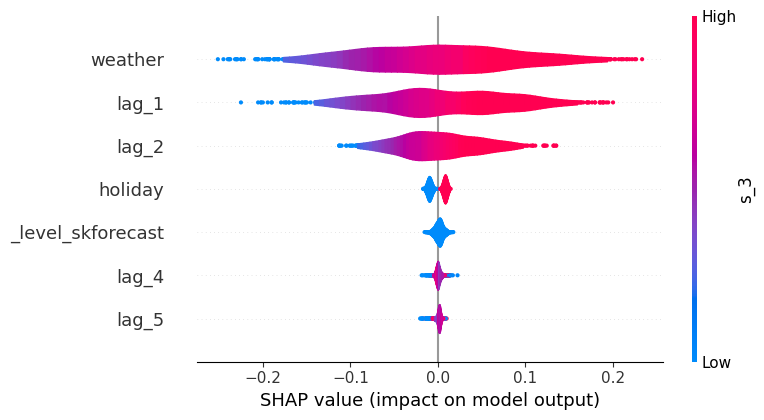

NameError: name 'ceil' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
from tsxp.dataset import ForecasterMsDataset, DatasetMapping
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection  import TimeSeriesFold

# define split date
split_date = "2026-12-31"

# df_exog["holiday"] = df_exog["holiday"].astype(bool) # SHAP has problems with bool

df_exog["holiday"] = df_exog["holiday"].astype(int) # bool is not supported by SHAP


mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)
# dataset.show_sizes()
dataset.plot_series()

def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [ 4, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
    }


regressor = LGBMRegressor()
print(regressor.get_params())

scaler = MinMaxScaler()
scaler = None

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster = ForecasterMsExog( 
    data = dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)

forecaster.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  

fi = ForecasterMsExogFeatureImportance(forecaster)


display(fi.feature_importance)
display(fi.feature_rank)
display(fi.relative_feature_importance)

fi.plot_importance_for_series()